This chapter will begin with an end-to-end example where we use a model and a tokenizer together to replicate the pipeline() function introduced in Chapter 1. Next, we’ll discuss the model API: we’ll dive into the model and configuration classes, and show you how to load a model and how it processes numerical inputs to output predictions.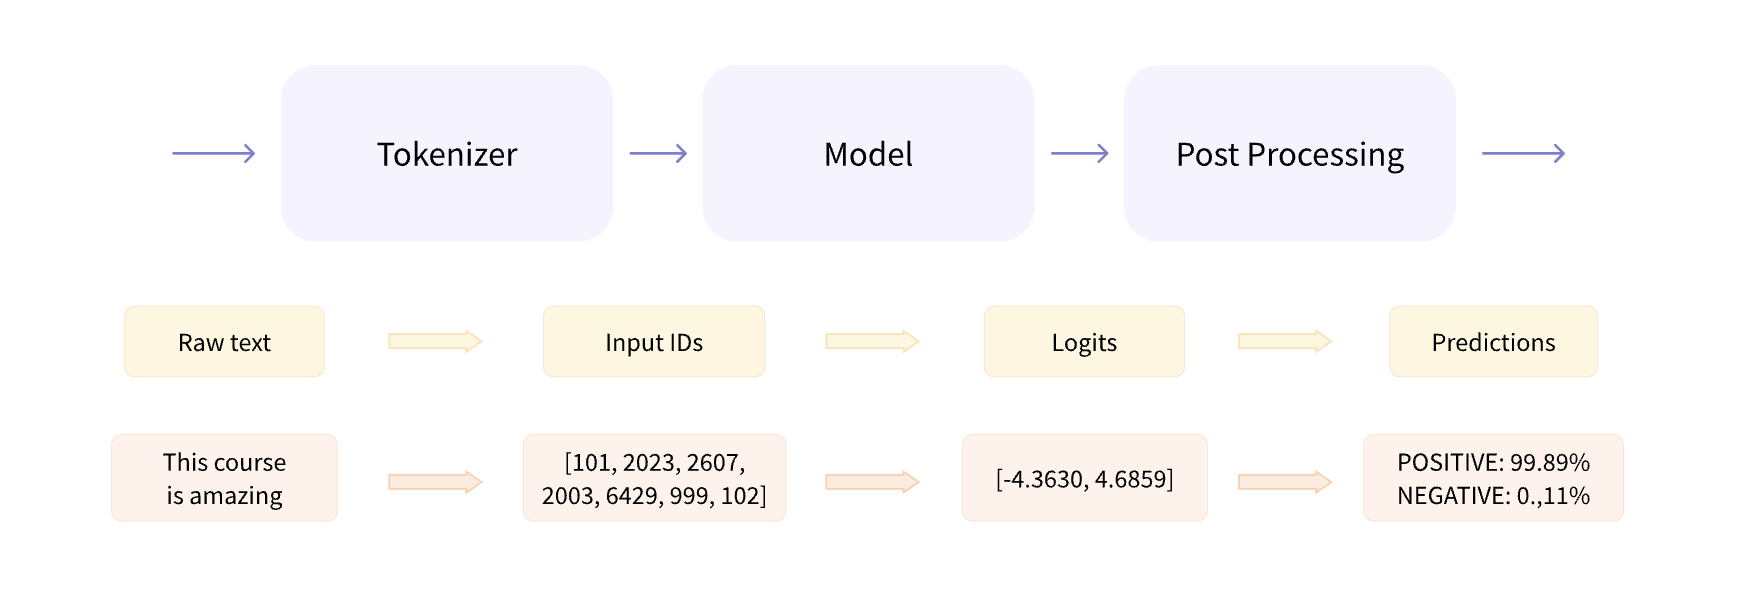

Then we’ll look at the tokenizer API, which is the other main component of the pipeline() function. Tokenizers take care of the first and last processing steps, handling the conversion from text to numerical inputs for the neural network, and the conversion back to text when it is needed. Finally, we’ll show you how to handle sending multiple sentences through a model in a prepared batch, then wrap it all up with a closer look at the high-level tokenizer() function.

In [ ]:
from transformers import pipeline
classifier=pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

this pipeline groups together three steps: preprocessing, passing the inputs through the model, and postprocessing:



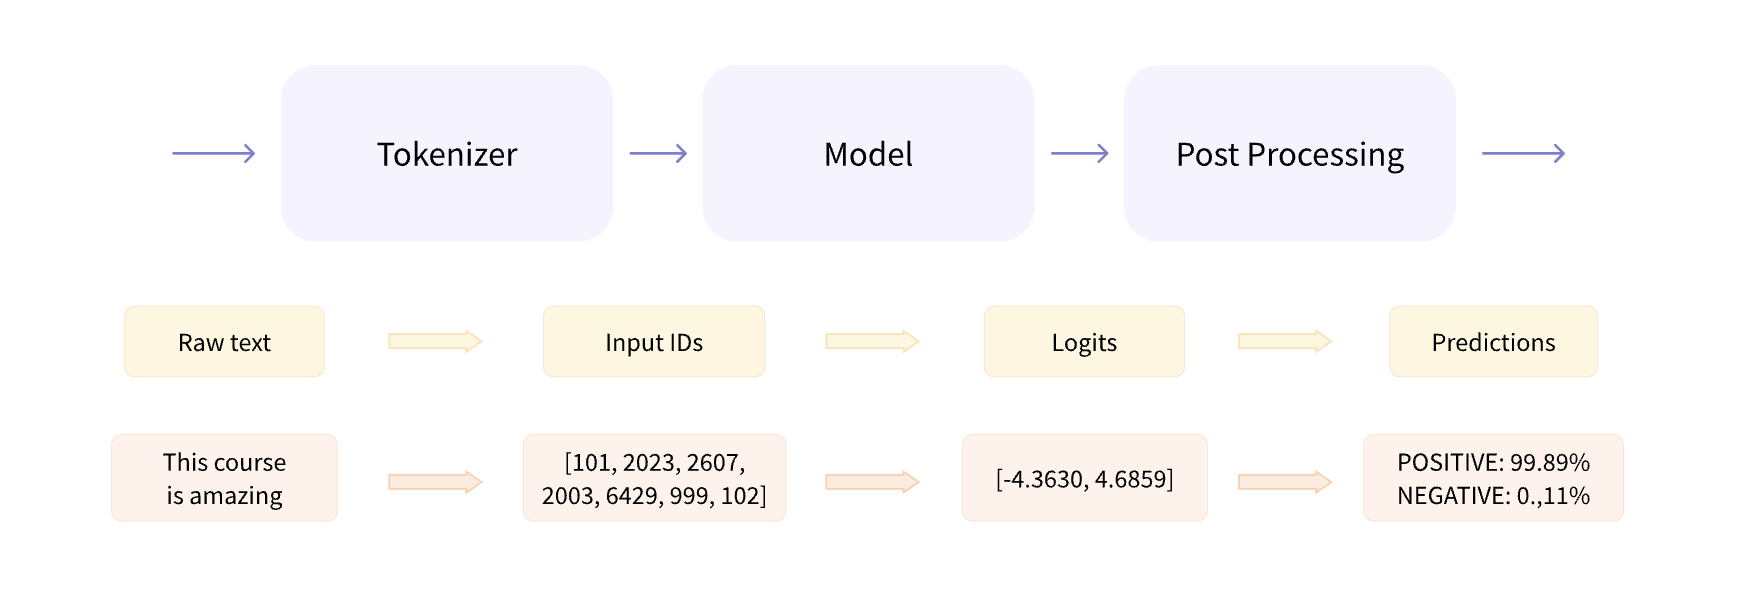

for preprocessing the data (to fed the data to model) we use tokenizer .Tokenizer coverts the words into tensors so the model can understand them.

Tokenizers basically preprocess the data so that the model can understand

Preprocessing with a tokenizer
===============================
Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens

Mapping each token to an integer

Adding additional inputs that may be useful to the model

we need to preprocess the data according the model we use to do this we use AutoTokenizer class and its from_pretrained() method. using the name of model it will automatically fetch the model tokenizer

In [ ]:
from transformers import AutoTokenizer

modelname="distilbert-base-uncased-finetuned-sst-2-english"
tokenizer=AutoTokenizer.from_pretrained(modelname)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

once we have the tokenizer we can give the input and tokenizer will generate a dictionary(tensors) we can feed to our model.

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]

inputs=tokenizer(raw_inputs,padding=True, truncation=True, return_tensors="pt")
print(inputs)

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}



Downloading and Going through the model:
========================================
We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an AutoModel class which also has a from_pretrained() method:




In [ ]:
from transformers import AutoModel
modelname="distilbert-base-uncased-finetuned-sst-2-english"
model=AutoModel.from_pretrained(modelname)

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Model heads: Making sense out of numbers
=========================================


The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension.

The output of the Transformer model(in the image Embeddings,layers and hidden states) is sent directly to the model head to be processed

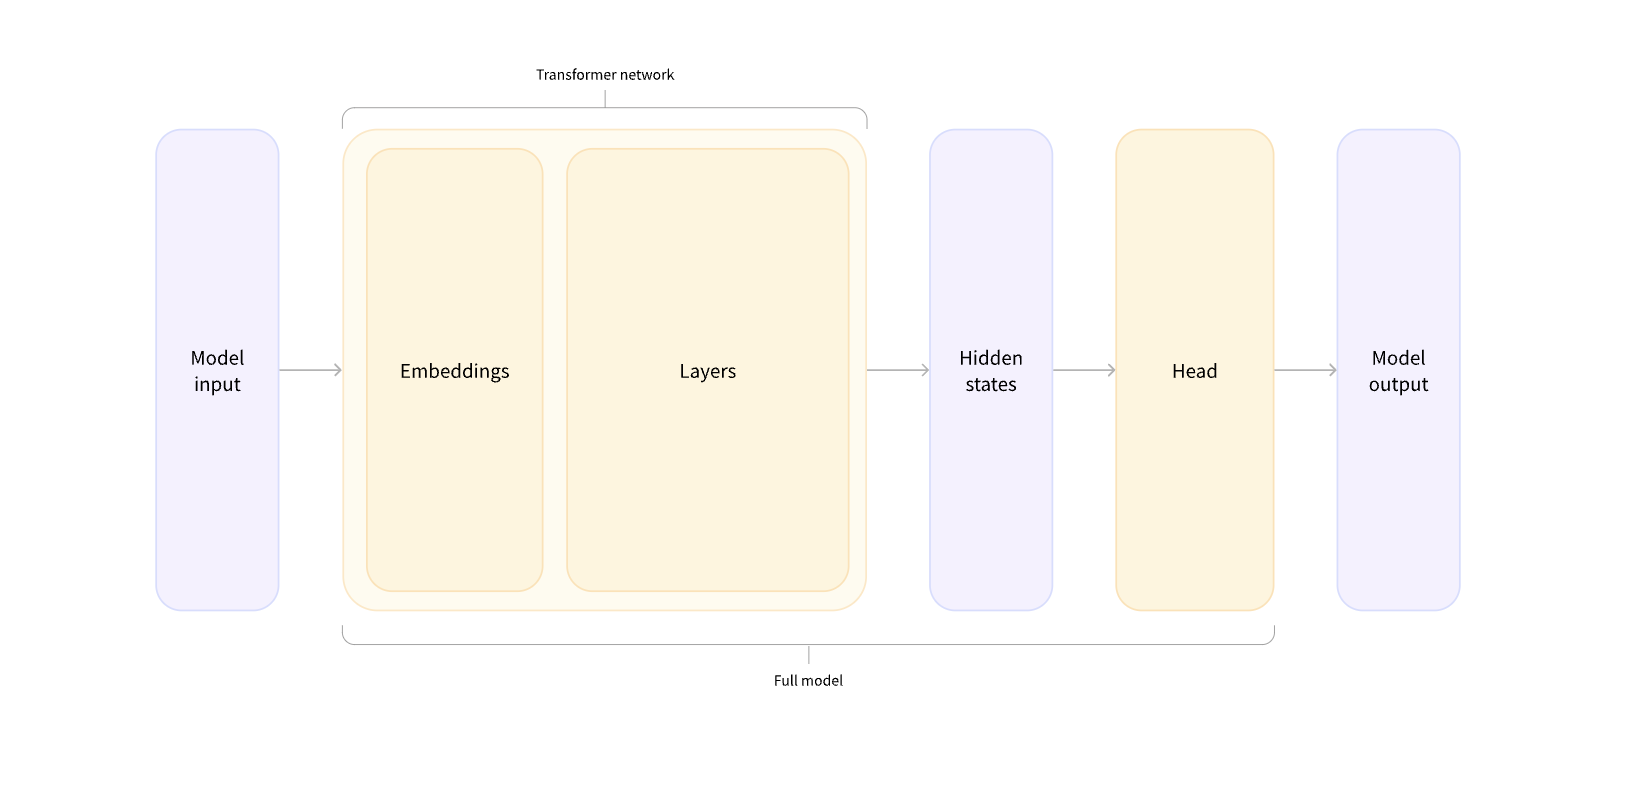



In this diagram, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

*Model (retrieve the hidden states)

*ForCausalLM

*ForMaskedLM

*ForMultipleChoice

*ForQuestionAnswering

*ForSequenceClassification

*ForTokenClassification

and others 🤗

** For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but AutoModelForSequenceClassification**

In [ ]:
from transformers import AutoModelForSequenceClassification
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

In [ ]:
print(outputs.logits.shape)

torch.Size([2, 2])


Postprocessing the output:
==========================

In [ ]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


To get the labels corresponding to each position, we can inspect the id2label attribute of the model config (more on this in the next section):

Copied


In [ ]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Models:
========
In this section we’ll take a closer look at creating and using a model. We’ll use the AutoModel class, which is handy when you want to instantiate any model from a checkpoint.

The AutoModel class and all of its relatives are actually simple wrappers over the wide variety of models available in the library. It’s a clever wrapper as it can automatically guess the appropriate model architecture for your checkpoint, and then instantiates a model with this architecture.

However, if you know the type of model you want to use, you can use the class that defines its architecture directly. Let’s take a look at how this works with a BERT model.

Creating a Transformer:
=======================

In [ ]:
from transformers import BertModel,BertConfig
#building the config
config=BertConfig()
#Building the model from config
model=BertModel(config)

The configuration contains many attributes that are used to build the model:

In [ ]:
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



While we haven’t seen what all of these attributes do yet, you should recognize some of them: the hidden_size attribute defines the size of the hidden_states vector, and num_hidden_layers defines the number of layers the Transformer model has.

Different loading methods:
=========================

In [ ]:
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

The model can be used in this state, but it will output gibberish; it needs to be trained first. We could train the model from scratch on the task at hand, but as you saw in Chapter 1, this would require a long time and a lot of data, and it would have a non-negligible environmental impact. To avoid unnecessary and duplicated effort, it’s imperative to be able to share and reuse models that have already been trained.

Loading a Transformer model that is already trained is simple — we can do this using the from_pretrained() method:

In [ ]:
from transformers import BertModel
model=BertModel.from_pretrained("bert-base-cased")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

As you saw earlier, we could replace BertModel with the equivalent AutoModel class. We’ll do this from now on as this produces checkpoint-agnostic code; if your code works for one checkpoint, it should work seamlessly with another. This applies even if the architecture is different, as long as the checkpoint was trained for a similar task.

In the code sample above we didn’t use BertConfig, and instead loaded a pretrained model via the bert-base-cased identifier. This is a model checkpoint that was trained by the authors of BERT themselves; you can find more details about it in its model card.

This model is now initialized with all the weights of the checkpoint. It can be used directly for inference on the tasks it was trained on, and it can also be fine-tuned on a new task. By training with pretrained weights rather than from scratch, we can quickly achieve good results.



Saving methods(for model):
===========================
Saving a model is as easy as loading one — we use the save_pretrained() method, which is analogous to the from_pretrained() method:

In [ ]:
model.save_pretrained("directory_on_my_computer")

Using a Transformer model for inference:
==========================================

Now that you know how to load and save a model, let’s try using it to make some predictions. Transformer models can only process numbers — numbers that the tokenizer generates. But before we discuss tokenizers, let’s explore what inputs the model accepts.

Tokenizers can take care of casting the inputs to the appropriate framework’s tensors, but to help you understand what’s going on, we’ll take a quick look at what must be done before sending the inputs to the model.

Let’s say we have a couple of sequences:

In [ ]:
sequences = ["Hello!", "Cool.", "Nice!"]

The tokenizer converts these to vocabulary indices which are typically called input IDs. Each sequence is now a list of numbers! The resulting output is:

In [ ]:
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]

This is a list of encoded sequences: a list of lists. Tensors only accept rectangular shapes (think matrices). This “array” is already of rectangular shape, so converting it to a tensor is easy:



In [ ]:
import torch

model_inputs = torch.tensor(encoded_sequences)

Using the tensors as inputs to the model:
==========================================
Making use of the tensors with the model is extremely simple — we just call the model with the inputs:

In [ ]:
output = model(model_inputs)

While the model accepts a lot of different arguments, only the input IDs are necessary. We’ll explain what the other arguments do and when they are required later, but first we need to take a closer look at the tokenizers that build the inputs that a Transformer model can understand

Tokenizers:
============

Tokenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data. In this section, we’ll explore exactly what happens in the tokenization pipeline.

There are lot of methods but we use subword tokenization for Tokenization !

Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords.

For instance, “annoyingly” might be considered a rare word and could be decomposed into “annoying” and “ly”. These are both likely to appear more frequently as standalone subwords, while at the same time the meaning of “annoyingly” is kept by the composite meaning of “annoying” and “ly”.

Here is an example showing how a subword tokenization algorithm would tokenize the sequence “Let’s do tokenization!“:






 **Unsurprisingly, there are many more techniques out there. To name a few:**

**Byte-level BPE, as used in GPT-2**

**WordPiece, as used in BERT**

**SentencePiece or Unigram, as used in several multilingual models**

**You should now have sufficient knowledge of how tokenizers work to get started with the API**

Loading and saving(tokenizer):
==============================
Loading and saving tokenizers is as simple as it is with models. Actually, it’s based on the same two methods: **from_pretrained() and save_pretrained()**. These methods will load or save the algorithm used by the tokenizer

Loading the BERT tokenizer trained with the same checkpoint as BERT is done the same way as loading the model, except we use the BertTokenizer class:

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Similar to AutoModel, the AutoTokenizer class will grab the proper tokenizer class in the library based on the checkpoint name, and can be used directly with any checkpoint:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [ ]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/special_tokens_map.json',
 'directory_on_my_computer/vocab.txt',
 'directory_on_my_computer/added_tokens.json',
 'directory_on_my_computer/tokenizer.json')

We’ll talk more about token_type_ids in Chapter 3, and we’ll explain the attention_mask key a little later. First, let’s see how the input_ids are generated. To do this, we’ll need to look at the intermediate methods of the tokenizer.

**Encoding**



Translating text to numbers is known as encoding. Encoding is done in a two-step process: the tokenization, followed by the conversion to input IDs.

As we’ve seen, the first step is to split the text into words (or parts of words, punctuation symbols, etc.), usually called tokens. There are multiple rules that can govern that process, which is why we need to instantiate the tokenizer using the name of the model, to make sure we use the same rules that were used when the model was pretrained.

The second step is to convert those tokens into numbers, so we can build a tensor out of them and feed them to the model. To do this, the tokenizer has a vocabulary, which is the part we download when we instantiate it with the from_pretrained() method. Again, we need to use the same vocabulary used when the model was pretrained.

To get a better understanding of the two steps, we’ll explore them separately. Note that we will use some methods that perform parts of the tokenization pipeline separately to show you the intermediate results of those steps, but in practice, you should call the tokenizer directly on your inputs

Tokenization:
==============
The tokenization process is done by the tokenize() method of the tokenizer:

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


**From tokens to input IDs**

The conversion to input IDs is handled by the convert_tokens_to_ids() tokenizer method:

In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]


Decoding:
=========

Decoding is going the other way around: from vocabulary indices, we want to get a string. This can be done with the decode() method as follows:

In [ ]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


Note that the decode method not only converts the indices back to tokens, but also groups together the tokens that were part of the same words to produce a readable sentence. This behavior will be extremely useful when we use models that predict new text

**How do we handle multiple sequences?**
**How do we handle multiple sequences of different lengths?
Are vocabulary indices the only inputs that allow a model to work well?
Is there such a thing as too long a sequence?
Let’s see what kinds of problems these questions pose, and how we can solve them using the 🤗 Transformers API.**

**Model expects a batch of inputs**
In the previous exercise you saw how sequences get translated into lists of numbers. Let’s convert this list of numbers to a tensor and send it to the model:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

IndexError: too many indices for tensor of dimension 1

Hypothesis:

The error is caused by the input tensor input_ids being one-dimensional. The DistilBertForSequenceClassification model expects a two-dimensional input tensor of shape (batch_size, sequence_length). The user has provided a one-dimensional tensor of shape (sequence_length).



In [ ]:
#this is the best practice
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])


Let’s try again and add a new dimension:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


**Batching is the act of sending multiple sentences through the model, all at once. If you only have one sentence, you can just build a batch with a single sequence:**

In [ ]:
batched_ids = [ids, ids]

Batching allows the model to work when you feed it multiple sentences. Using multiple sequences is just as simple as building a batch with a single sequence. There’s a second issue, though. When you’re trying to batch together two (or more) sentences, they might be of different lengths. If you’ve ever worked with tensors before, you know that they need to be of rectangular shape, so you won’t be able to convert the list of input IDs into a tensor directly. To work around this problem, we usually pad the inputs.

**Padding the inputs**

we are proving the batched_ids ourselves

The following list of lists cannot be converted to a tensor:

In [ ]:
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

In order to work around this, we’ll use padding to make our tensors have a rectangular shape. Padding makes sure all our sentences have the same length by adding a special word called the padding token to the sentences with fewer values. For example, if you have 10 sentences with 10 words and 1 sentence with 20 words, padding will ensure all the sentences have 20 words. In our example, the resulting tensor looks like this:

In [ ]:
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

The padding token ID can be found in tokenizer.pad_token_id. Let’s use it and send our two sentences through the model individually and batched together:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


There’s something wrong with the logits in our batched predictions: the second row should be the same as the logits for the second sentence, but we’ve got completely different values!

This is because the key feature of Transformer models is attention layers that contextualize each token. These will take into account the padding tokens since they attend to all of the tokens of a sequence. To get the same result when passing individual sentences of different lengths through the model or when passing a batch with the same sentences and padding applied, we need to tell those attention layers to ignore the padding tokens. This is done by using an attention mask.

Attention masks:
=================

Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s: 1s indicate the corresponding tokens should be attended to, and 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model).

Let’s complete the previous example with an attention mask:

In [ ]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


Now we get the same logits for the second sentence in the batch.

Notice how the last value of the second sequence is a padding ID, which is a 0 value in the attention mask.

**putting all the above content together**

When you call your tokenizer directly on the sentence, you get back inputs that are ready to pass through your model:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs)

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs1 = tokenizer(sequences)

print(model_inputs1)

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


padding according to several objectives

In [ ]:
# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)

truncation of sequences

In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)

the tokenizer can handle conversion of tensors to  that can be directly sent to model.this ca be done using this.

In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# Returns TensorFlow tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="tf")

# Returns NumPy arrays
model_inputs = tokenizer(sequences, padding=True, return_tensors="np")

**Special tokens**

If we take a look at the input IDs returned by the tokenizer, we will see they are a tiny bit different from what we had earlier:

In [ ]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102]
[1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


One token ID was added at the beginning, and one at the end. Let’s decode the two sequences of IDs above to see

In [ ]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] i've been waiting for a huggingface course my whole life. [SEP]
i've been waiting for a huggingface course my whole life.


The tokenizer added the special word [CLS] at the beginning and the special word [SEP] at the end. This is because the model was pretrained with those, so to get the same results for inference we need to add them as well. Note that some models don’t add special words, or add different ones; models may also add these special words only at the beginning, or only at the end. In any case, the tokenizer knows which ones are expected and will deal with this for you.

**Wrapping up: From tokenizer to model**

Now that we’ve seen all the individual steps the tokenizer object uses when applied on texts, let’s see one final time how it can handle multiple sequences (padding!), very long sequences (truncation!), and multiple types of tensors with its main API:


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]